<a href="https://colab.research.google.com/github/stanlee321/2019-DL-Beginners-NVIDIA-GPU-accelerated-Platform-in-an-instant/blob/master/Box_Convolution_demo_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install git+https://github.com/shrubb/box-convolutions.git

  Cloning https://github.com/shrubb/box-convolutions.git to /tmp/pip-req-build-5bquguuz
  Stored in directory: /tmp/pip-ephem-wheel-cache-5_hf7330/wheels/93/0b/53/72e8da537fed483c01c024853507020d4fe7cd4d69d9e3acf6
Successfully built box-convolution


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

mnist_train = datasets.MNIST('./', train=True, download=True, transform=transforms.ToTensor())
mnist_test  = datasets.MNIST('./', train=False, transform=transforms.ToTensor())

Processing...
Done!


In [0]:
from box_convolution import BoxConv2d

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = BoxConv2d(1, 40, 28, 28)
    self.conv1_1x1 = nn.Conv2d(40, 40, 1, 1)

    self.fc1 = nn.Linear(7*7*40, 10)

  def forward(self, x):
    # The following line computes responses to 40 "generalized Haar filters"
    x = self.conv1_1x1(self.conv1(x))
    x = F.relu(F.max_pool2d(x, 4))

    x = self.fc1(x.view(-1, 7*7*40))
    return F.log_softmax(x, dim=1)

In [0]:
def train(model, device, train_loader, optimizer, epoch):
  """Trains `model` for one epoch"""
  model.train()
  
  for batch_idx, (data, target) in enumerate(train_loader):
    # get a screenshot of boxes
    if batch_idx % 100 == 0:
      # box importances will be useful for highliting
      box_importances = model.conv1_1x1.weight \
        .detach().float().abs().max(0)[0].squeeze()
      box_importances /= box_importances.max()
      boxes_plot = \
        model.conv1.draw_boxes(resolution=(300,300), weights=box_importances)
      
      # `boxes_plots` is defined below in the cell with actual training
      boxes_plots.append(boxes_plot)

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    
    if batch_idx % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    for g in optimizer.param_groups:
        g['lr'] *= 0.999
        
def test(model, device, test_loader):
  model.eval()
  
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      # sum up batch loss
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      # get the index of the max log-probability
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [0]:
# Training settings
use_cuda = torch.cuda.is_available()
batch_size = 64
n_epochs = 2

In [0]:
torch.manual_seed(666)
device = torch.device('cuda' if use_cuda else 'cpu')

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    mnist_test,  batch_size=batch_size, shuffle=True, **kwargs)

In [0]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [0]:
boxes_plots = []

for epoch in range(1, n_epochs+1):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295127
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.677091
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.579455
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.355202
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.261899
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.445261
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.152108
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.218782
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.243840
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.370447

Test set: Average loss: 0.1781, Accuracy: 9497/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.182357
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.108834
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.105382
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.143580
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.116735
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.077526
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.154235
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.094403
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.247873
T

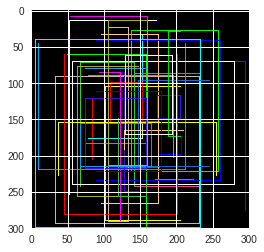

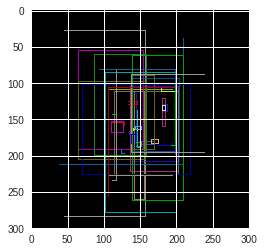

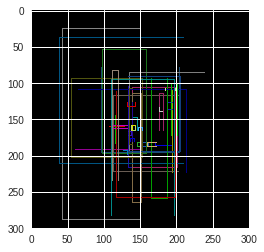

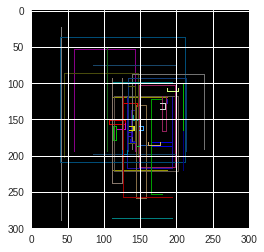

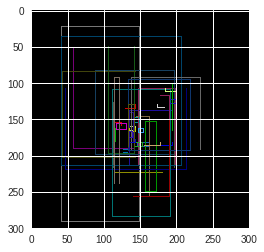

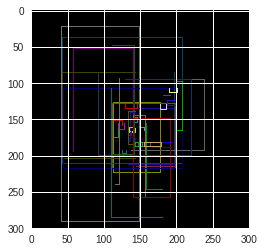

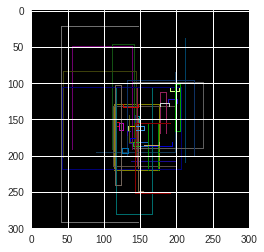

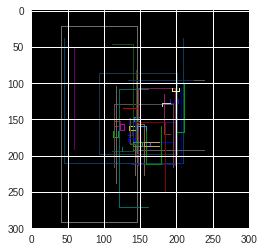

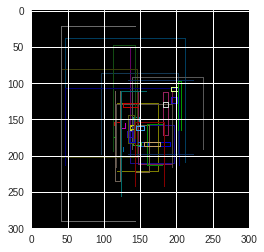

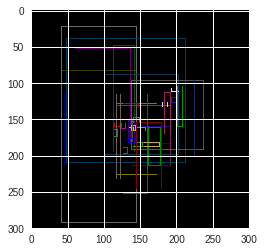

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

for boxes_plot in boxes_plots[::2]:
  plt.figure()
  plt.imshow(boxes_plot)